**Group members:**

Ritika Giridhar   -   a1907667

Sakshi Sinha      -   a1898508


#**Importing Modules And Loading The Dataset**

We used pandas for data manipulation, scikit-learn for item encoding and similarity calculations, and scipy for effective handling of data structures, among other libraries. Our datasets, train_big and test_big, which contain historical purchase data for developing and testing our recommendation algorithm, depend on these imports to function properly. The model is developed using the training data, which is stored in train_data, and its performance is assessed using the testing data, which is stored in test_data.

In [ ]:
#Importing modules
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from itertools import combinations
from collections import Counter
import numpy as np
from tabulate import tabulate



In [ ]:
# Loading datasets
train_data_path = '/content/basket_data_by_date_train_big.csv'
test_data_path = '/content/basket_data_by_date_test_big.csv'
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

#**Data Analysis**

We conducted a thorough exploration of the train_data dataset using Pandas, Matplotlib, and Seaborn during our "Data Analysis" phase, which is detailed in Section 3 of the report. We evaluated item quantities and price distributions, examined its structure, found the best-selling item pairs, and determined the top revenue items. We were able to discover high-revenue items, highlight popular products for new customers, and find item pairs suitable for recommendations. Our recommendation techniques were strongly influenced by these findings.

**1. Dataset summary and item overview (see section 3.1 of report)**

In [ ]:
# Basic statistics for numerical columns to get an overview of the dataset
train_data_describe = train_data.describe()

# Overview of item counts and unique values
item_overview = {
    "Unique Items": train_data['Itemname'].nunique(),
    "Unique Transactions": train_data['BillNo'].nunique(),
    "Unique Customers": train_data['CustomerID'].nunique()
}

train_data_describe, item_overview


(              BillNo       Quantity          Price     CustomerID  \
 count  200000.000000  200000.000000  200000.000000  200000.000000   
 mean   555444.533915       3.720960       3.609832   15461.086845   
 std     10778.632198       2.763365       4.928895    1687.747367   
 min    536365.000000       1.000000       0.060000   12347.000000   
 25%    546084.000000       1.000000       1.650000   14096.000000   
 50%    555653.000000       3.000000       2.550000   15464.000000   
 75%    565324.000000       6.000000       4.250000   16931.000000   
 max    572741.000000      10.000000     295.000000   18287.000000   
 
                 cost  CustomerID_encoded  Itemname_encoded  
 count  200000.000000       200000.000000     200000.000000  
 mean       11.227514         1921.159230       1856.525155  
 std        11.995236         1036.141053        995.598923  
 min         0.100000            0.000000          0.000000  
 25%         3.300000         1091.000000       1036.75000

**2. Distribution of quantity and price in the training data (see section 3.2 of report)**

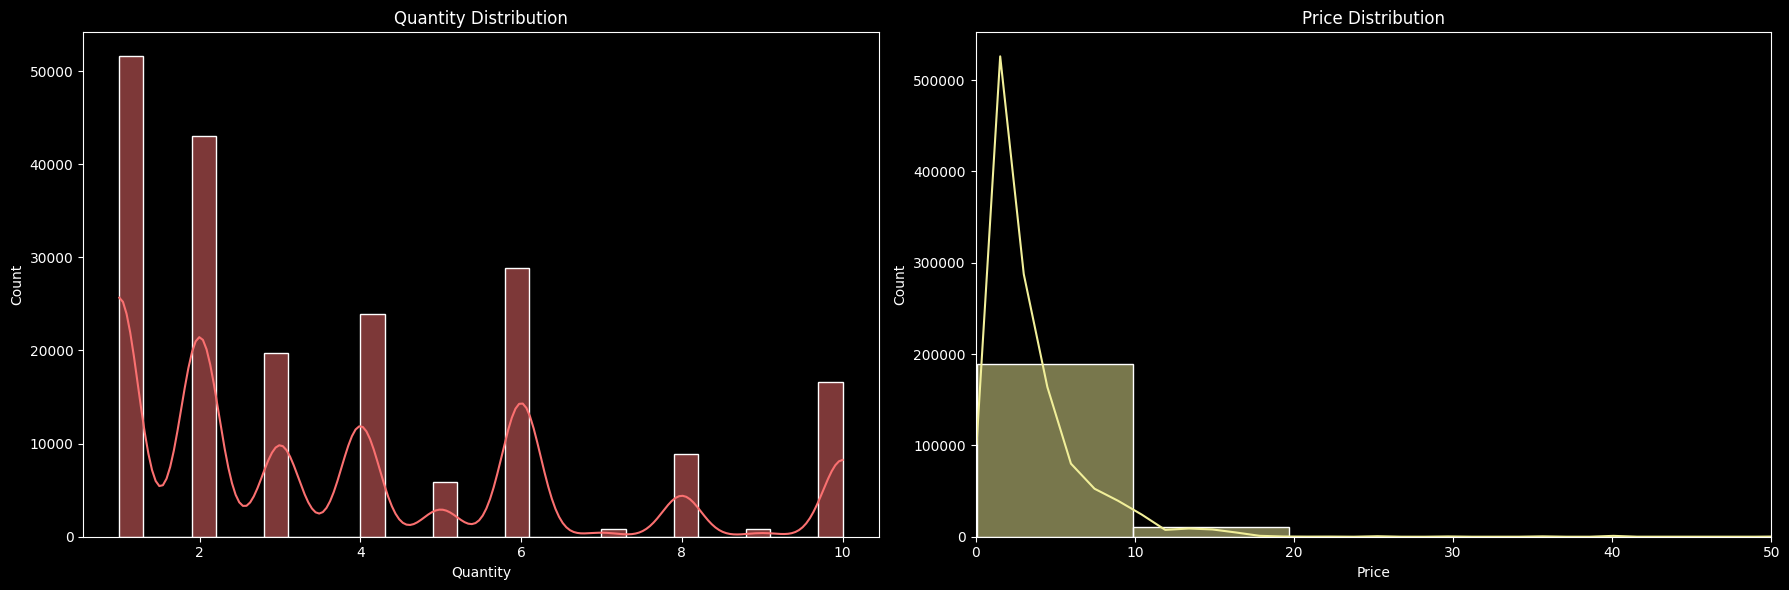

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the dark background
plt.style.use('dark_background')

# Setting up the figure for distribution plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Quantity distribution
sns.histplot(train_data, x="Quantity", bins=30, kde=True, ax=ax[0], color='#FA7070')
ax[0].set_title("Quantity Distribution")

# Price distribution (limiting range for better visibility)
sns.histplot(train_data, x="Price", bins=30, kde=True, ax=ax[1], color='#F1EF99')
ax[1].set_xlim(0, 50)
ax[1].set_title("Price Distribution")


plt.tight_layout()
plt.show()


**3. Top 10 most common item pairs in the training data (see section 3.3 of report)**

In [ ]:
# Step 1: Group by BillNo and collect all items in each bill
bills_items = train_data.groupby('BillNo')['Itemname'].apply(list)

# Step 2 & 3: For each bill, find all unique item pairs and count occurrences
item_pairs_counter = Counter()
for items in bills_items:
    # Create all combinations of item pairs for each bill
    for item_pair in combinations(set(items), 2):
        item_pairs_counter[item_pair] += 1

# Step 4: Find the top 10 most common item pairs
top_item_pairs = item_pairs_counter.most_common(10)

# Format the data for tabulate
table_data = [(pair[0], pair[1], count) for pair, count in top_item_pairs]

# Create the table with a format suitable for dark themes
table = tabulate(table_data, headers=['Item 1', 'Item 2', 'Count'], tablefmt="pretty")

print(table)

+---------------------------------+-----------------------------------+-------+
|             Item 1              |              Item 2               | Count |
+---------------------------------+-----------------------------------+-------+
|     LUNCH BAG PINK POLKADOT     |      LUNCH BAG RED RETROSPOT      |  360  |
|     LUNCH BAG RED RETROSPOT     |      LUNCH BAG  BLACK SKULL.      |  336  |
|     LUNCH BAG PINK POLKADOT     |      LUNCH BAG  BLACK SKULL.      |  325  |
|   ALARM CLOCK BAKELIKE GREEN    |     ALARM CLOCK BAKELIKE RED      |  312  |
| ROSES REGENCY TEACUP AND SAUCER |  GREEN REGENCY TEACUP AND SAUCER  |  306  |
|     JUMBO BAG RED RETROSPOT     |      JUMBO BAG PINK POLKADOT      |  289  |
|       LUNCH BAG WOODLAND        |      LUNCH BAG RED RETROSPOT      |  286  |
|   WOODEN FRAME ANTIQUE WHITE    | WOODEN PICTURE FRAME WHITE FINISH |  281  |
|       LUNCH BAG CARS BLUE       |      LUNCH BAG  BLACK SKULL.      |  276  |
|         SPOTTY BUNTING          |     

**4. Top 20 most frequently purchased items (see section 3.4 of report)**

<ipython-input-58-922cc6cc44dd>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=frequent_items.index, x=frequent_items.values, palette="coolwarm")


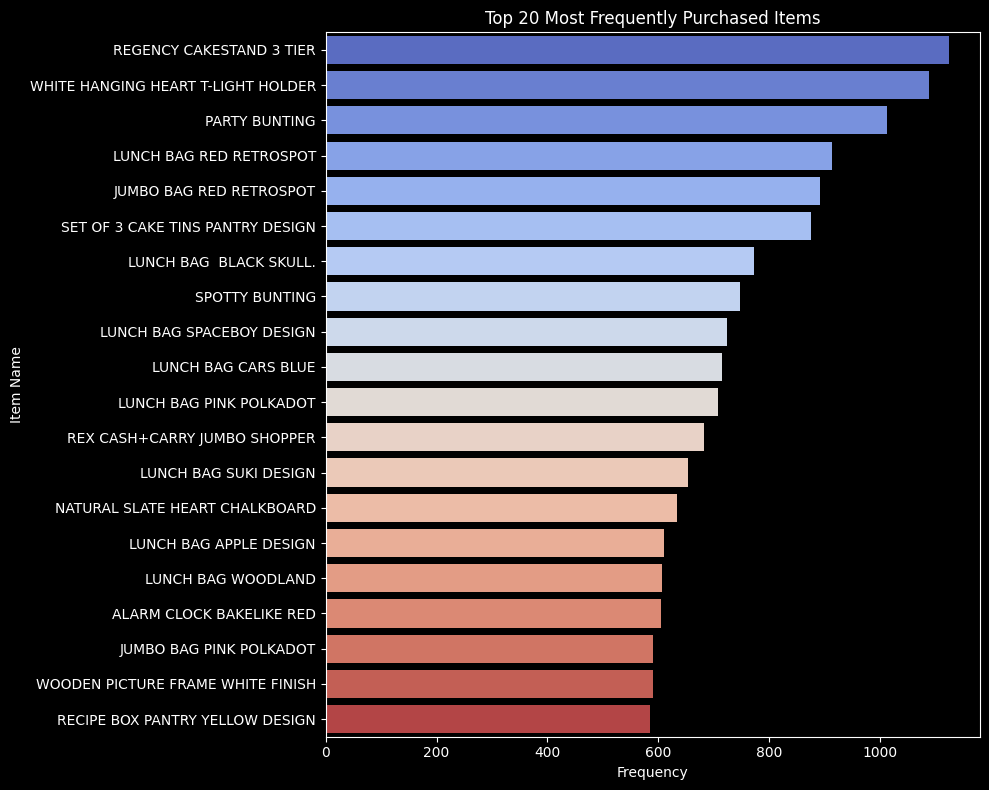

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identifying the most frequently purchased items
frequent_items = train_data['Itemname'].value_counts().head(20)

# Plotting the top 20 most frequently purchased items
plt.figure(figsize=(10, 8))
sns.barplot(y=frequent_items.index, x=frequent_items.values, palette="coolwarm")
plt.title("Top 20 Most Frequently Purchased Items")
plt.xlabel("Frequency")
plt.ylabel("Item Name")
plt.tight_layout()
plt.show()


**5. Monthly transaction volume (see section 3.5 of report)**

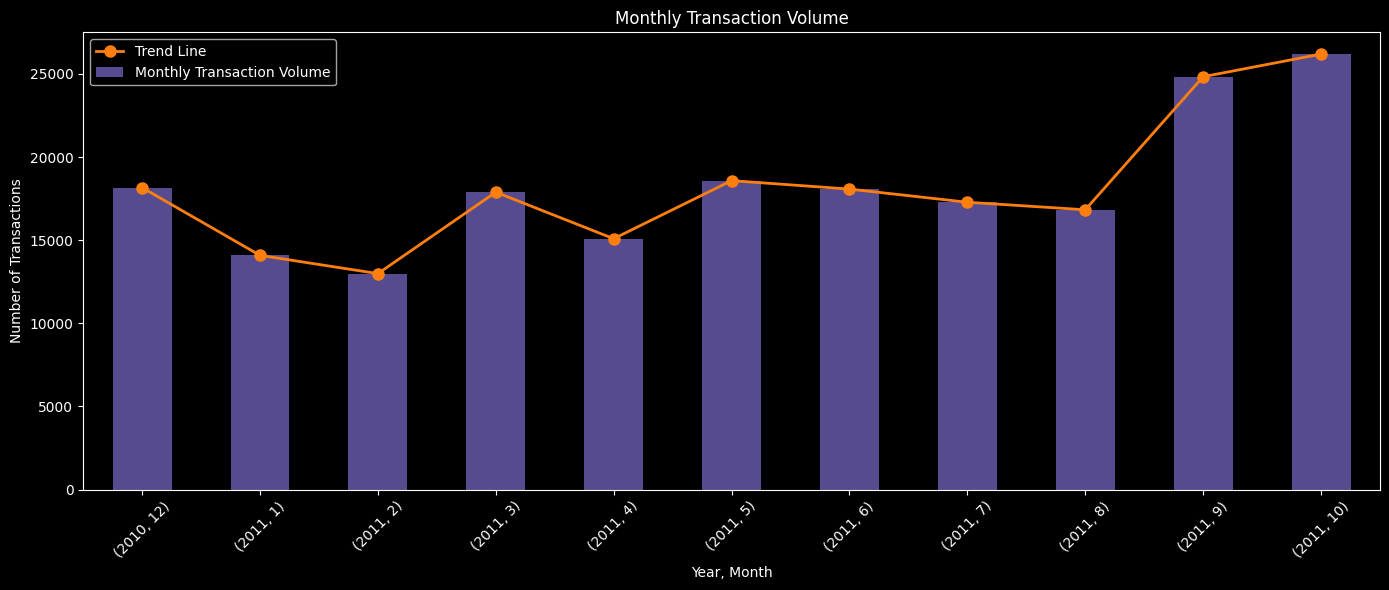

(Year  Month
 2010  12       18159
 2011  1        14087
       2        12989
       3        17888
       4        15088
 dtype: int64,
 Timestamp('2010-12-01 08:26:00'),
 Timestamp('2011-10-25 15:47:00'))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converting 'Date' column to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d/%m/%Y %H:%M')

# Extracting date components for analysis
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['Weekday'] = train_data['Date'].dt.weekday
train_data['Hour'] = train_data['Date'].dt.hour

# Aggregating data to observe trends over months
monthly_sales = train_data.groupby(['Year', 'Month']).size()

# Plotting monthly sales trends
plt.figure(figsize=(14, 6))
monthly_sales.plot(kind='bar', color='#574b90')  # Dark purple color for bars
plt.title('Monthly Transaction Volume')
plt.xlabel('Year, Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

# Adding trend line connecting tops of bars
x_values = [f'{year}-{month}' for year, month in monthly_sales.index]  # Convert index to strings
plt.plot(x_values, monthly_sales.values, marker='o', color='#FF7F0E', linewidth=2, markersize=8, label='Trend Line')  # Orange color for trend line

# Adding legend
plt.legend(['Trend Line', 'Monthly Transaction Volume'])

plt.tight_layout()
plt.show()

monthly_sales.head(), train_data['Date'].min(), train_data['Date'].max()


**6. Distribution of transaction volume by the day of the week (see section 3.5 of report)**

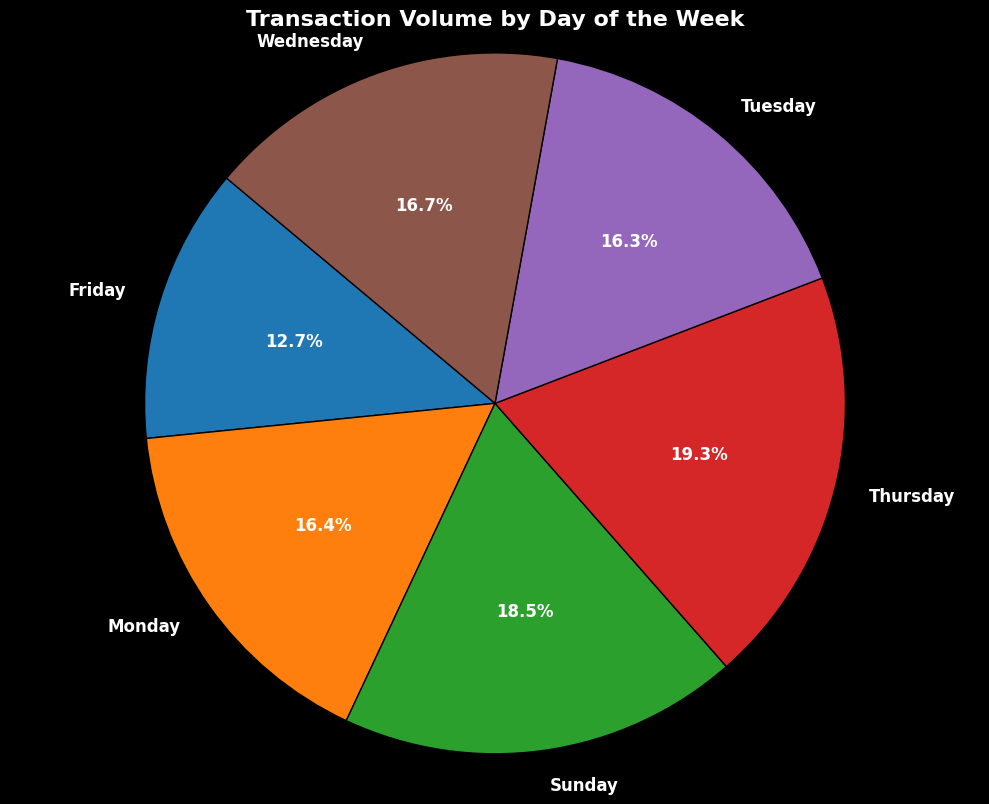

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregating transaction data by day of the week
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Weekday'] = train_data['Date'].dt.day_name()
weekday_transactions = train_data.groupby('Weekday').size()

# Define custom dark colors for the pie chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Plotting transaction volume by day of the week in a dark-themed pie chart with white lines
plt.figure(figsize=(10, 8))
plt.pie(weekday_transactions, labels=weekday_transactions.index, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12, 'fontweight': 'bold'}, wedgeprops={'edgecolor': 'black'})
plt.title('Transaction Volume by Day of the Week', fontsize=16, fontweight='bold', color='white')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()




**7. Top revenue-generating items (see section 3.7 of report)**

In [ ]:
# Calculating total revenue for each item in the larger dataset
item_revenue_large = train_data.groupby('Itemname')['cost'].sum().sort_values(ascending=False)

# Identifying the top 10 profitable items in the larger dataset
top_profitable_items_large = item_revenue_large.head(10)

top_profitable_items_large


Itemname
REGENCY CAKESTAND 3 TIER              36107.92
PARTY BUNTING                         21623.77
SPOTTY BUNTING                        14572.80
WHITE HANGING HEART T-LIGHT HOLDER    14508.66
JUMBO BAG RED RETROSPOT               13450.22
SET OF 3 CAKE TINS PANTRY DESIGN      13221.79
DOORMAT KEEP CALM AND COME IN         12229.25
DOORMAT RED RETROSPOT                 11572.95
JAM MAKING SET WITH JARS              11517.86
DOORMAT UNION FLAG                    11377.35
Name: cost, dtype: float64

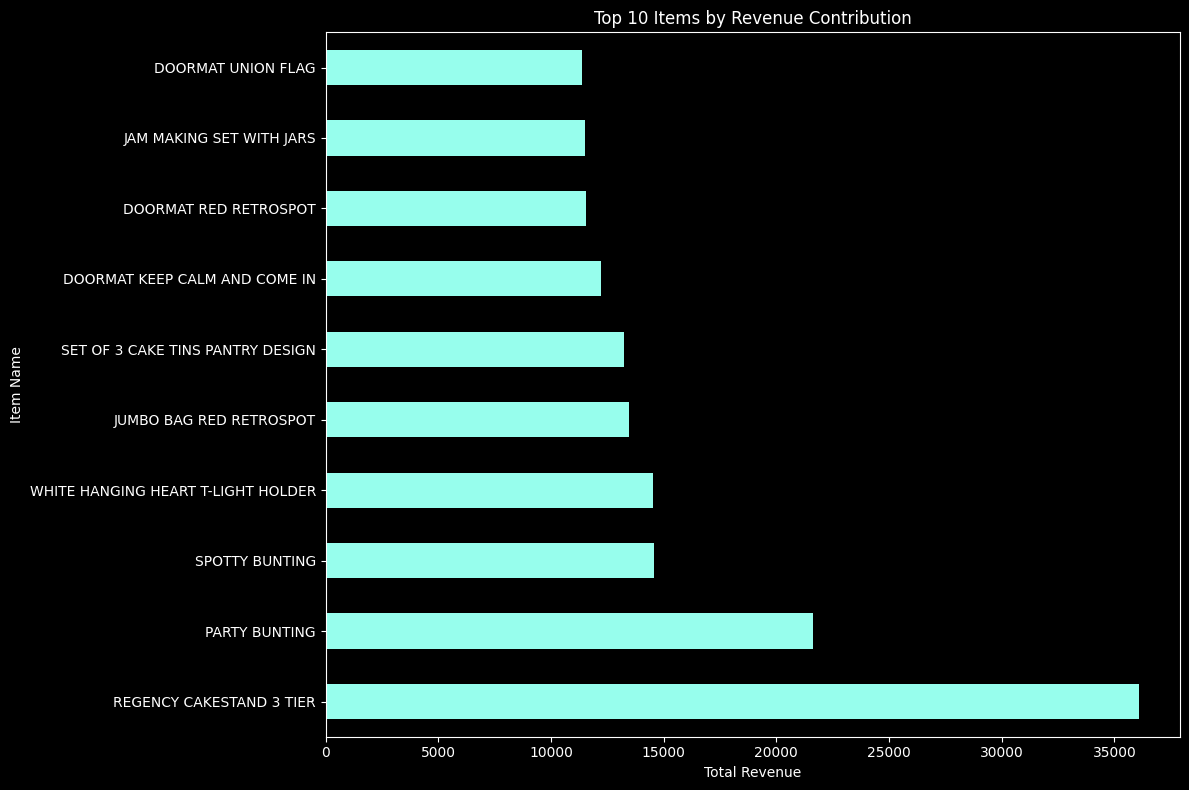

In [ ]:
# Revenue Contribution by Top Items
plt.figure(figsize=(12, 8))
top_profitable_items_large.plot(kind='barh', color='#97FEED')
plt.title('Top 10 Items by Revenue Contribution')
plt.xlabel('Total Revenue')
plt.ylabel('Item Name')


plt.tight_layout()
plt.show()


#**Recommendation System Implemention**

We created two recommendation systems to study the impact of pattern mining on item recommendations.

1. **Recommendations with Top Pairs**:

   **Objective**: This system is designed to propose items to users by leveraging the items already present in their current cart, while also considering the top frequent item pairs.  
   
   **Process**: Initially, it checks whether the item is within the encoder classes. If not, it employs the "get_similar_items_for_unseen" function to retrieve similar items. For items within the encoder classes, it calculates similarity scores between the item and others using cosine similarity, then selects the top-N similar items. Additionally, it integrates items from the top frequent item pairs that include the current item.
   
   **Output**: The system furnishes a list of recommended item pairs for the user's cart.

2. **Recommendations without Top Pairs**:
   
   **Objective**: In contrast, this system offers suggestions for a user's cart without taking into account top frequent item pairs.
   
   **Process**: Similarly, it begins by confirming if the item is within the encoder classes and retrieves similar items if it's not. For items within the encoder classes, it computes similarity scores and selects the top-N similar items. However, unlike the previous system, it excludes consideration of top frequent item pairs.
   
   **Output**: This system likewise presents a list of recommended item pairs for the user's cart.







In [ ]:
# Encoding CustomerID and Itemname
customer_encoder = LabelEncoder()
item_encoder = LabelEncoder()
train_data['CustomerID_encoded'] = customer_encoder.fit_transform(train_data['CustomerID'].astype(str))
train_data['Itemname_encoded'] = item_encoder.fit_transform(train_data['Itemname'].astype(str))

# Creating the user-item matrix from the training data
user_item_matrix = csr_matrix((train_data['Quantity'], (train_data['CustomerID_encoded'], train_data['Itemname_encoded'])))

# Compute similarity matrices
item_item_similarity = cosine_similarity(user_item_matrix.T, dense_output=False)

# Identify frequent item pairs
pair_combinations = train_data.groupby('CustomerID')['Itemname'].apply(lambda items: combinations(items, 2))
flat_pairs = [tuple(sorted(pair)) for sublist in pair_combinations for pair in sublist if len(set(pair)) == 2]
pair_counts = Counter(flat_pairs)
top_pairs = pair_counts.most_common(10)



In [ ]:
def get_similar_items_for_unseen(item_name):
    """
    Function to get similar items for an unseen item.

    Parameters:
    item_name (str): The name of the unseen item for which similar items need to be retrieved.

    Returns:
    similar_items (list): A list containing names of similar items to the unseen item.
    """
    # Get unique item names from the training data
    known_items = train_data['Itemname'].unique()

    # Choose two random items from the list of known items
    similar_items = np.random.choice(known_items, size=2, replace=False).tolist()

    return similar_items


In [ ]:
def recommend_items_with_top_pairs(user_id, current_cart_items, item_encoder, user_item_matrix, top_pairs, top_n=5):
    """
    Recommends items to a user based on the items in their current cart, considering top pairs.

    Parameters:
    user_id (int): The ID of the user for whom recommendations are being generated.
    current_cart_items (list): List of items currently in the user's cart.
    item_encoder: Encoder for mapping item names to numerical indices.
    user_item_matrix: Matrix representing user-item interactions.
    top_pairs (list): List of top frequent item pairs.
    top_n (int): Number of recommendations to generate for each item in the cart. Default is 5.

    Returns:
    recommendations (list): List of recommended item pairs for the user.
    """
    recommendations = []
    for item in current_cart_items:
        item_recommendations = set()
        # If the item is not in the encoder classes, get similar items
        if item not in item_encoder.classes_:
            similar_items = get_similar_items_for_unseen(item)
            item_recommendations.update(similar_items)
        else:
            encoded_item = item_encoder.transform([item])[0]
            sim_scores = cosine_similarity(user_item_matrix.T[encoded_item], user_item_matrix.T).flatten()
            sorted_indices = np.argsort(-sim_scores)[1:top_n+1]
            item_recommendations.update(item_encoder.inverse_transform(sorted_indices))

        # Include items from top pairs if they contain the current item
        for pair, _ in top_pairs:
            if item in pair:
                item_recommendations.update(pair)

        recommendations.extend([(item, rec) for rec in item_recommendations if rec not in current_cart_items])

    return recommendations[:top_n]


def recommend_items_without_top_pairs(user_id, current_cart_items, item_encoder, user_item_matrix, top_n=5):
    """
    Recommends items for a user's cart without considering top frequent item pairs.

    Parameters:
    user_id: ID of the user.
    current_cart_items (list): List of items in the user's current cart.
    item_encoder: Encoder for mapping item names to numerical indices.
    user_item_matrix: Matrix representing user-item interactions.
    top_n (int): Number of recommendations to return. Default is 5.

    Returns:
    recommendations (list): List of recommended item pairs for the user's cart.
    """
    recommendations = []
    for item in current_cart_items:
        # If the item is not in the encoder classes, get similar items
        if item not in item_encoder.classes_:
            similar_items = get_similar_items_for_unseen(item)
            recommendations.extend([(item, rec) for rec in similar_items])
        else:
            encoded_item = item_encoder.transform([item])[0]
            sim_scores = cosine_similarity(user_item_matrix.T[encoded_item], user_item_matrix.T).flatten()
            sorted_indices = np.argsort(-sim_scores)[1:top_n+1]
            recommended_items = item_encoder.inverse_transform(sorted_indices)
            recommendations.extend([(item, rec) for rec in recommended_items if rec not in current_cart_items])

    return recommendations[:top_n]




#**Testing Recommendation System against Test Dataset**

We evaluated the effectiveness of our recommendation system that incorporates pattern mining. We tested it against the test dataset and presented the results. Specifically, we showcased the customer ID, the initial item in the transaction (antecedent), and the recommended item (consequent). This allowed us to observe how our recommendation system provides varied suggestions for different initial items and assess its relevance.

In [ ]:
# Applying recommendations and aggregating results
aggregated_results = {}
for user_id in test_data['CustomerID'].unique():
    current_cart_items = test_data[test_data['CustomerID'] == user_id]['Itemname'].unique().tolist()
    # Ensure you pass all necessary arguments according to the updated function signature
    recommendations = recommend_items_with_top_pairs(user_id, current_cart_items, item_encoder, user_item_matrix, top_pairs, top_n=3)
    for antecedent, recommended in recommendations:
        key = (user_id, antecedent)  # Unique key for each user and antecedent item pair
        if key not in aggregated_results:
            aggregated_results[key] = set()
        aggregated_results[key].add(recommended)

# Prepare data for DataFrame
display_data = []
for (user_id, antecedent), recommended_items in aggregated_results.items():
    display_data.append({
        'Customer ID': user_id,
        'Antecedent Item': antecedent,
        'Recommended Items': ', '.join(recommended_items)
    })

# Convert to DataFrame
recommendations_df = pd.DataFrame(display_data)


In [ ]:
recommendations_df

,Customer ID,Antecedent Item,Recommended Items
0,14341,CHRISTMAS CRAFT LITTLE FRIENDS,CHRISTMAS CRAFT WHITE FAIRY
1,14341,BISCUIT TIN 50'S CHRISTMAS,"SET OF 6 NATIVITY MAGNETS, BISCUIT TIN VINTAGE..."
2,14482,WOODEN STAR CHRISTMAS SCANDINAVIAN,FOLKART CLIP ON STARS
3,14482,RECYCLING BAG RETROSPOT,"BLUE POLKADOT PURSE, TOY TIDY SPACEBOY"
4,14085,SET OF 4 JAM JAR MAGNETS,SET OF 5 LUCKY CAT MAGNETS
...,...,...,...
2580,12713,CHILDRENS CUTLERY POLKADOT BLUE,CHILDRENS CUTLERY POLKADOT GREEN
2581,12713,EMBROIDERED RIBBON REEL DAISY,"EMBROIDERED RIBBON REEL ROSIE, EMBROIDERED RIB..."
2582,12680,CHILDRENS CUTLERY SPACEBOY,CHILDRENS CUTLERY POLKADOT PINK
2583,12680,CHILDRENS CUTLERY CIRCUS PARADE,CHILDRENS CUTLERY POLKADOT PINK


#**Evaluation**

We conducted a complete evaluation of our recommendation system utilising two different ways to comprehensively examine its performance:



**1. Performance evaluation and similarity score reporting**

**Method**: We assess the recommendation patterns by masking one item from the user's cart and comparing the similarity between the recommended item and the masked one. This assessment can be conducted both with and without considering item patterns.

**Process**: We randomly select a subset of users and their corresponding dates from the test dataset and evaluate the recommendation system's performance by comparing the recommended items with the actual purchases made by users on those dates. We assign a performance score based on the relevance of the recommendations, considering a recommendation successful if the similarity between the recommended and masked items exceeds 50%.

**Output**: The evaluation results consist of a detailed report featuring user IDs, dates, cart items, masked items (selected for evaluation), recommended items, and their corresponding similarity scores.

In [ ]:
def select_masked_item(cart_items, user_item_matrix, item_encoder, top_pairs_dict):
    """
    Selects an item from the user's cart to be masked for evaluation.

    Parameters:
    cart_items (list): List of items in the user's cart.
    user_item_matrix: Matrix representing user-item interactions.
    item_encoder: Encoder for mapping item names to numerical indices.
    top_pairs_dict (dict): Dictionary containing top frequent item pairs.

    Returns:
    masked_item: Item selected to be masked from the cart.
    """
    if not cart_items:
        return None
    # Check if any item is in the top pairs list first
    for item in cart_items:
        if item in top_pairs_dict:
            return item
    # If none are in top pairs, select based on similarity
    similarities = []
    for item in cart_items:
        if item not in item_encoder.classes_:
            continue
        encoded_item = item_encoder.transform([item])[0]
        other_items = [o for o in cart_items if o != item and o in item_encoder.classes_]
        if not other_items:
            continue
        other_encoded_items = item_encoder.transform(other_items)
        sim_scores = cosine_similarity(
            user_item_matrix.T[encoded_item],
            user_item_matrix.T[other_encoded_items]).flatten()
        avg_sim = np.mean(sim_scores)
        similarities.append((item, avg_sim))
    if similarities:
        return max(similarities, key=lambda x: x[1])[0]
    return None

def evaluate_and_report(test_data, user_item_matrix, item_encoder, top_pairs, use_patterns=True, num_users=10):
    """
    Evaluates and reports the performance of recommendation patterns by masking one of the items present in the user's cart
    and comparing the similarity of the recommended item with the masked item, considering or not considering item patterns.

    Parameters:
    test_data: Data for testing the recommendation system.
    user_item_matrix: Matrix representing user-item interactions.
    item_encoder: Encoder for mapping item names to numerical indices.
    top_pairs (list): List of top frequent item pairs.
    use_patterns (bool): Flag to determine whether to consider item patterns. Default is True.
    num_users (int): Number of users to evaluate. Default is 10.

    Returns:
    performance_score (float): The performance score of the recommendation system.
    detailed_results_df (DataFrame): Detailed results of the evaluation.
    """
    np.random.seed(42)
    wins = 0
    detailed_results = []

    user_date_counts = test_data.groupby(['CustomerID', 'Date']).size()
    valid_user_dates = user_date_counts[(user_date_counts >= 5) & (user_date_counts <= 7)].reset_index()
    sampled_user_dates = valid_user_dates.sample(n=min(num_users, len(valid_user_dates)), random_state=42)

    for _, row in sampled_user_dates.iterrows():
        user_id, date = row['CustomerID'], row['Date']
        user_cart = test_data[(test_data['CustomerID'] == user_id) & (test_data['Date'] == date)]['Itemname'].tolist()

        masked_item = select_masked_item(user_cart, user_item_matrix, item_encoder, top_pairs if use_patterns else [])

        if not masked_item:
            continue
        remaining_cart = [item for item in user_cart if item != masked_item]

        # Function call is now simplified with consistent parameters
        if use_patterns:
          recommendations = recommend_items_with_top_pairs(
            user_id, remaining_cart, item_encoder, user_item_matrix, top_pairs, top_n=5)
        else:
          recommendations = recommend_items_without_top_pairs(
            user_id, remaining_cart, item_encoder, user_item_matrix, top_n=5)


        recommended_items = [rec[1] for rec in recommendations]

        similarity_scores = []
        if masked_item in item_encoder.classes_:
            masked_item_encoded = item_encoder.transform([masked_item])[0]
            rec_items_encoded = item_encoder.transform([item for item in recommended_items if item in item_encoder.classes_])
            similarity_matrix = cosine_similarity(user_item_matrix.T[masked_item_encoded], user_item_matrix.T[rec_items_encoded]).flatten()
            similarity_scores = list(similarity_matrix)
            if any(score >= 0.5 for score in similarity_scores):
                wins += 1

        detailed_results.append({
            'User ID': user_id,
            'Date': date,
            'Items in Cart': ', '.join(user_cart),
            'Masked Item': masked_item,
            'Recommended Items': ', '.join(recommended_items),
            'Similarity Scores': ', '.join([f"{score:.2f}" for score in similarity_scores])
        })

    performance_score = wins / len(detailed_results) if detailed_results else 0
    detailed_results_df = pd.DataFrame(detailed_results)
    return performance_score, detailed_results_df



In [ ]:
# Evaluate with pattern mining
performance_score, detailed_report_df = evaluate_and_report(test_data, user_item_matrix, item_encoder, top_pairs, use_patterns=True)
print(f"Performance with Pattern Mining:")
print(tabulate(detailed_report_df, headers='keys', tablefmt='psql', showindex=False))
print(f"\nRecommendation System Performance Score: {performance_score:.2f}")


# Evaluate without pattern mining
print("\n\n\n")
performance_score, detailed_report_df = evaluate_and_report(test_data, user_item_matrix, item_encoder, top_pairs, use_patterns=False)
print(f"Performance without Pattern Mining:")
print(tabulate(detailed_report_df, headers='keys', tablefmt='psql', showindex=False))
print(f"\nRecommendation System Performance Score: {performance_score:.2f}")



Performance with Pattern Mining:
+-----------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+
|   User ID | Date             | Items in Cart                                                                                                                                                                                                           | Masked Item                       | Recommended Items                                                                                                                                             | Similarity Scores            |
|----------

**2. Generating masked recommendation examples**

**Method**: We generate recommendation examples using both top pairs and without considering top pairs to observe the recommendation system's behavior under different circumstances.

**Process**: Iterating over the train and test dataset for each top frequent item pair, we create diverse examples while ensuring user uniqueness. Recommendations are made based on these pairs, considering the utilisation of top pairs.

**Output**: The output comprises recommendation examples for both scenarios: with and without top pairs. Each example includes details such as user ID, cart item, the other item in the pair, recommended items, and the method used (with or without top pairs).

In [ ]:
def find_top_frequent_patterns(data):
    """
    Finds the top frequent item pairs in the dataset.

    Parameters:
    data (DataFrame): DataFrame containing transaction data with 'CustomerID' and 'Itemname' columns.

    Returns:
    sorted_pairs (list): List of top frequent item pairs sorted by support.
    """
    # Generate all combinations of item pairs for each customer
    pair_combinations = data.groupby('CustomerID')['Itemname'].apply(lambda x: list(combinations(x, 2)))

    # Flatten the list of combinations and count occurrences of each pair
    pairs_flat = [tuple(sorted(pair)) for sublist in pair_combinations for pair in sublist]
    pair_counts = Counter(pairs_flat)

    # Calculate total number of transactions (baskets)
    total_baskets = data['CustomerID'].nunique()

    # Calculate support for each pair and sort them
    pair_supports = {pair: count / total_baskets for pair, count in pair_counts.items()}
    sorted_pairs = sorted(pair_supports.items(), key=lambda x: x[1], reverse=True)

    return sorted_pairs[:10]


# Find top 5 frequent patterns in the training set
top_10_train = find_top_frequent_patterns(train_data)
# Find top 5 frequent patterns in the test set
top_10_test = find_top_frequent_patterns(test_data)

# Display the results
print("Top 10 Frequent Patterns in Training Set:")
print(tabulate(top_10_train, headers=['Item Pair', 'Support'], tablefmt='psql'))

print("\nTop 10 Frequent Patterns in Test Set:")
print(tabulate(top_10_test, headers=['Item Pair', 'Support'], tablefmt='psql'))


Top 10 Frequent Patterns in Training Set:
+--------------------------------------------------------------+-----------+
| Item Pair                                                    |   Support |
|--------------------------------------------------------------+-----------|
| ('LUNCH BAG  BLACK SKULL.', 'LUNCH BAG RED RETROSPOT')       |  0.73703  |
| ('LUNCH BAG RED RETROSPOT', 'LUNCH BAG SUKI DESIGN')         |  0.680758 |
| ('LUNCH BAG CARS BLUE', 'LUNCH BAG RED RETROSPOT')           |  0.656053 |
| ('LUNCH BAG APPLE DESIGN', 'LUNCH BAG RED RETROSPOT')        |  0.653857 |
| ('LUNCH BAG PINK POLKADOT', 'LUNCH BAG RED RETROSPOT')       |  0.643151 |
| ('LUNCH BAG  BLACK SKULL.', 'LUNCH BAG CARS BLUE')           |  0.64123  |
| ('LUNCH BAG RED RETROSPOT', 'LUNCH BAG SPACEBOY DESIGN')     |  0.631348 |
| ('CHARLOTTE BAG SUKI DESIGN', 'RED RETROSPOT CHARLOTTE BAG') |  0.619819 |
| ('JUMBO BAG RED RETROSPOT', 'LUNCH BAG RED RETROSPOT')       |  0.601427 |
| ('LUNCH BAG  BLACK SKULL.', 'LUN

In [ ]:
def generate_masked_recommendation_examples(test_data, user_item_matrix, item_encoder, top_pairs, use_top_pairs=True, used_users=None):
    """
    Generates masked recommendation examples based on top pairs.

    Parameters:
    test_data (DataFrame): DataFrame containing test transaction data.
    user_item_matrix (numpy.ndarray): Matrix representing user-item interactions.
    item_encoder (LabelEncoder): Encoder for item names.
    top_pairs (list): List of top item pairs.
    use_top_pairs (bool): Flag to indicate whether to use top pairs in recommendation.
    used_users (set): Set of users already used in examples.

    Returns:
    recommendation_examples (list): List of recommendation examples.
    used_users (set): Updated set of used users.
    """
    if used_users is None:
        used_users = set()

    recommendation_examples = []

    def recommend(item, user_id, use_top_pairs):
        current_cart = [item]
        if use_top_pairs:
            return recommend_items_with_top_pairs(user_id, current_cart, item_encoder, user_item_matrix, top_pairs, top_n=3)
        else:
            return recommend_items_without_top_pairs(user_id, current_cart, item_encoder, user_item_matrix, top_n=3)

    # Iterate over each top pair
    for pair, _ in top_pairs:
        # Generate examples for each pair, ensuring diversity and user uniqueness
        for _, row in test_data.iterrows():
            user_id = row['CustomerID']
            if user_id in used_users:
                continue  # Skip if this user has already been used

            # Check if the user's transaction includes either item of the pair
            if row['Itemname'] in pair:
                masked_item = pair[0] if row['Itemname'] == pair[1] else pair[1]
                recommendations = recommend(row['Itemname'], user_id, use_top_pairs)

                # Check if the masked item is in the recommendations
                recommended_items = [rec[1] for rec in recommendations]
                if masked_item in recommended_items:
                    recommendation_examples.append({
                        'User ID': user_id,
                        'Cart Item': row['Itemname'],
                        'Other Item in Pair': masked_item,
                        'Recommendations': ', '.join(recommended_items),
                        'Method Used': 'With Top Pairs' if use_top_pairs else 'Without Top Pairs'
                    })
                    used_users.add(user_id)  # Ensure this user is not used again for another example
                    break  # Move to the next pair after a successful example

    return recommendation_examples, used_users



In [ ]:
# Generating examples with top pairs on the test dataset
test_examples_with_top_pairs, test_used_users = generate_masked_recommendation_examples(
    test_data, user_item_matrix, item_encoder, top_10_test, use_top_pairs=True
)

# Generating examples without top pairs on the test dataset, passing in the users already used
test_examples_without_top_pairs, _ = generate_masked_recommendation_examples(
    test_data, user_item_matrix, item_encoder, top_10_test, use_top_pairs=False, used_users=test_used_users
)

print("On Test Dataset")
print("Recommendations With Top Pairs:\n")
test_examples_with_df = pd.DataFrame(test_examples_with_top_pairs)
print(tabulate(test_examples_with_df, headers='keys', tablefmt='psql', showindex=False))

print("\n\n")  # Print some newlines to separate the tables visually
print("Recommendations Without Top Pairs:\n")
test_examples_without_df = pd.DataFrame(test_examples_without_top_pairs)
print(tabulate(test_examples_without_df, headers='keys', tablefmt='psql', showindex=False))


On Test Dataset
Recommendations With Top Pairs:

+-----------+-----------------------------------+-----------------------------------+--------------------------------------------------------------------------------------------------------+----------------+
|   User ID | Cart Item                         | Other Item in Pair                | Recommendations                                                                                        | Method Used    |
|-----------+-----------------------------------+-----------------------------------+--------------------------------------------------------------------------------------------------------+----------------|
|     17841 | GARDENERS KNEELING PAD CUP OF TEA | GARDENERS KNEELING PAD KEEP CALM  | LIPSTICK PEN RED, HOT WATER BOTTLE KEEP CALM, GARDENERS KNEELING PAD KEEP CALM                         | With Top Pairs |
|     14096 | SMALL HANGING IVORY/RED WOOD BIRD | LIPSTICK PEN RED                  | SET OF 3 WOODEN HEART DECORATIONS

In [ ]:
# Generating examples with top pairs on the train dataset
train_examples_with_top_pairs, train_used_users = generate_masked_recommendation_examples(
    train_data, user_item_matrix, item_encoder, top_10_train, use_top_pairs=True
)

# Generating examples without top pairs on the train dataset, passing in the users already used
train_examples_without_top_pairs, _ = generate_masked_recommendation_examples(
    train_data, user_item_matrix, item_encoder, top_10_train, use_top_pairs=False, used_users=train_used_users
)

print("\n\nOn Train Dataset")
print("Recommendations With Top Pairs:\n")
train_examples_with_df = pd.DataFrame(train_examples_with_top_pairs)
print(tabulate(train_examples_with_df, headers='keys', tablefmt='psql', showindex=False))

print("\n\n")  # Print some newlines to separate the tables visually
print("Recommendations Without Top Pairs:\n")
train_examples_without_df = pd.DataFrame(train_examples_without_top_pairs)
print(tabulate(train_examples_without_df, headers='keys', tablefmt='psql', showindex=False))




On Train Dataset
Recommendations With Top Pairs:

+-----------+---------------------------+-----------------------------+------------------------------------------------------------------------------------+----------------+
|   User ID | Cart Item                 | Other Item in Pair          | Recommendations                                                                    | Method Used    |
|-----------+---------------------------+-----------------------------+------------------------------------------------------------------------------------+----------------|
|     16218 | LUNCH BAG  BLACK SKULL.   | LUNCH BAG RED RETROSPOT     | LUNCH BAG SUKI DESIGN, LUNCH BAG PINK POLKADOT, LUNCH BAG RED RETROSPOT            | With Top Pairs |
|     14688 | LUNCH BAG RED RETROSPOT   | LUNCH BAG SUKI DESIGN       | LUNCH BAG SUKI DESIGN, LUNCH BAG SPACEBOY DESIGN, LUNCH BAG APPLE DESIGN           | With Top Pairs |
|     17920 | LUNCH BAG CARS BLUE       | LUNCH BAG RED RETROSPOT     | LUNCH 